In [118]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [119]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [120]:
# Load dataset
data = pd.read_csv(r'D:\Master\Sem I\Practical Machine Learning\MoviePlotsGenre\date\cleaned_data.csv')

In [121]:
# Define a dictionary for genre mapping
genre_mapping = {
    'Drama': 'Drama',
    'Romance': 'Romance',
    'Comedy': 'Comedy',
    'Action': 'Action',
    'Adventure': 'Action',
    'Sci-Fi': 'Science Fiction',
    'Fantasy': 'Science Fiction',
    'Horror': 'Horror',
    'Thriller': 'Horror',
    'Biography': 'Biography',
    'Documentary': 'Biography',
    'Musical': 'Other',
    'Western': 'Other',
    'War': 'Other',
    'Crime': 'Drama',
}


In [122]:
# Simplify genres
def simplify_genres(data):
    data['Genre'] = data['Genre'].str.split('|').str[0]
    data['Genre'] = data['Genre'].map(genre_mapping).fillna('Other')
    return data

data = simplify_genres(data)

In [123]:
# Initialize the lemmatizer and stopword list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


In [124]:
# Preprocess text
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text.lower())
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return cleaned_tokens

In [125]:

data['cleaned_plot'] = data['Plot'].apply(preprocess_text)

In [126]:
print(data[['Plot', 'cleaned_plot']].head())

                                                Plot  \
0  Boone's daughter befriends an Indian maiden as...   
1  Before heading out to a baseball game at a nea...   
2  The plot is that of a black woman going to the...   
3  On a beautiful summer day a father and mother ...   
4  A thug accosts a girl as she leaves her workpl...   

                                        cleaned_plot  
0  [boone, daughter, befriends, indian, maiden, b...  
1  [heading, baseball, game, nearby, ballpark, sp...  
2  [plot, black, woman, going, dentist, toothache...  
3  [beautiful, summer, day, father, mother, take,...  
4  [thug, accosts, girl, leaf, workplace, man, re...  


In [127]:
# Train Word2Vec on the tokenized plots
word2vec_model = Word2Vec(sentences=data['cleaned_plot'], vector_size=100, window=5, min_count=2, workers=4)

In [128]:
# Generate word2vec embeddings
def get_average_word2vec(plot_tokens, model, vector_size):
    vectors = [model.wv[word] for word in plot_tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

data['plot_vector'] = data['cleaned_plot'].apply(lambda x: get_average_word2vec(x, word2vec_model, 100))



In [129]:
def combine_features(data, plot_vector_weight=1.0):
    # Columns to exclude from numeric feature selection
    exclude_columns = ['Genre', 'Plot', 'cleaned_plot', 'Wiki Page']
    
    # Select numeric features and scale them
    numeric_features = data.drop(columns=exclude_columns, errors='ignore').select_dtypes(include=[np.number])
    scaler = StandardScaler()
    numeric_features_scaled = scaler.fit_transform(numeric_features.fillna(0))
    
    # Extract `plot_vector` embeddings and apply weighting
    plot_vectors = np.stack(data['plot_vector'].values)
    plot_vectors_weighted = plot_vectors * plot_vector_weight  # Scale plot_vector embeddings
    
    # Combine weighted plot_vector embeddings with scaled numeric features
    combined = np.hstack((plot_vectors_weighted, numeric_features_scaled))
    
    return combined


In [130]:
X = combine_features(data, plot_vector_weight=5)

In [131]:
# Print included columns in features for verification
def print_included_columns(data, exclude_columns):
    included_columns = [col for col in data.columns if col not in exclude_columns]
    print("Columns included in features:")
    for col in included_columns:
        print(col)

In [132]:
exclude_columns = ['Genre', 'Plot', 'cleaned_plot', 'Wiki Page']
print_included_columns(data, exclude_columns)

Columns included in features:
Release Year
Title
Origin/Ethnicity
Director
Cast
plot_vector


In [133]:
# Initialize and fit OPTICS)

optics_model = OPTICS(min_samples=5, metric='euclidean', xi=0.05, min_cluster_size=0.005, max_eps=2.0)
optics_model.fit(X)

# Add cluster labels to the dataset
data['cluster'] = optics_model.labels_

In [134]:
# Map clusters to predicted genres (optional, for interpretability)
def map_clusters_to_genres(data):
    cluster_to_genre = (
        data.groupby('cluster')['Genre']
        .agg(lambda x: x.value_counts().idxmax() if len(x) > 0 else "Unknown")
        .to_dict()
    )
    data['predicted_genre'] = data['cluster'].map(cluster_to_genre)
    return data

In [135]:
data = map_clusters_to_genres(data)

In [136]:
# Evaluate clustering performance
def evaluate_clustering(data, feature_matrix):
    valid_mask = data['cluster'] != -1  # Exclude noise points (-1)
    valid_features = feature_matrix[valid_mask]
    valid_clusters = data['cluster'][valid_mask]

    # Check for valid clusters
    if len(set(valid_clusters)) > 1:
        silhouette = silhouette_score(valid_features, valid_clusters)
    else:
        silhouette = "Not Applicable (fewer than 2 clusters)"

    ari = adjusted_rand_score(data['Genre'], data['predicted_genre'])
    nmi = normalized_mutual_info_score(data['Genre'], data['predicted_genre'])

    return silhouette, ari, nmi

In [137]:
silhouette, ari, nmi = evaluate_clustering(data, X)

In [138]:
# Print results
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

# Cluster distribution
print("\nCluster distribution:")
print(data['cluster'].value_counts())

Silhouette Score: Not Applicable (fewer than 2 clusters)
Adjusted Rand Index (ARI): 1.000
Normalized Mutual Information (NMI): 1.000

Cluster distribution:
cluster
-1    28064
Name: count, dtype: int64


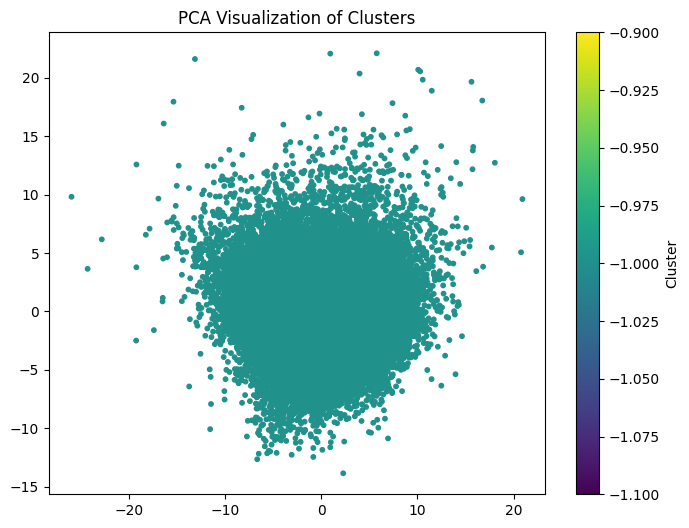

In [139]:
# PCA Visualization
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data['cluster'], cmap='viridis', s=10)
plt.title("PCA Visualization of Clusters")
plt.colorbar(label='Cluster')
plt.show()

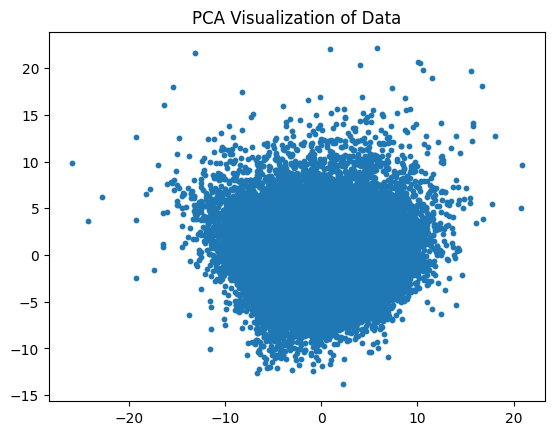

In [140]:
# Visualize the first two components of PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10)
plt.title("PCA Visualization of Data")
plt.show()
